# 0. Getting started

### System

#### Windows

|                |                                                   |
|----------------|---------------------------------------------------|
| Выпуск         | Windows 10 Pro                                    |
| Версия         | 22H2                                              |
| Дата установки | 18.09.2020                                        |
| Сборка ОС      | 19045.3570                                        |
| Взаимодействие | Windows Feature Experience Pack 1000.19052.1000.0 |

#### WSL2

|                |         |         |
|----------------|---------|---------|
|   NAME         | STATE   | VERSION |
| * Ubuntu-20.04 | Running | 2       |

##### Ubuntu

|                |                    |
|----------------|--------------------|
| Distributor ID | Ubuntu             |
| Description    | Ubuntu 22.04.3 LTS |
| Release        | 22.04              |
| Codename       | jammy              |

##### mamba

|           |        |
|-----------|--------|
| **mamba** | 1.4.2  |
| **conda** | 23.3.1 |

### Tips

Jupyter notebook:  
*   `%%bash` - выполнить команды в `bash`;
*   `%%file name.txt` - записать содержимое ячейки в файл `name.txt`.

Bash:
*   `path_to_dir=$(pwd)`  # Записать в переменную результат выполнения команды `pwd`  
                        # Важно: не `path`! Зарезервирована под переменные окружения  
                        # Можно подставлять, если программа требует абсолютный адрес:  
*   `fastqc -o . $path_to_dir/example.fastq.gz`

### Create working directory

In [ ]:
%%bash
cd /mnt/f/Documents/Bioinformatics_Institute/Semester_project
mkdir -p code/scripts
mkdir -p data_folder/raw_data && mkdir -p data_folder/processed_data && mkdir -p data_folder/imgs

mkdir programms

### Create virtual enviroment

In [ ]:
%%bash
mamba create -n stas_project python=3.10
mamba activate stas_project

git init
git branch -m master main

In [ ]:
%%cmd  # Windows 10 Pro 22H2, Miniforge3-23.3.1-1.4.2., Miniforge Prompt

mamba create -n stas_project python=3.10
mamba activate stas_project

### Install tools

In [ ]:
%%bash
mamba install -c bioconda fastqc
fastqc --version
# FastQC v0.12.1

mamba install -c bioconda trimmomatic
trimmomatic -version
# 0.39

mamba install -c bioconda bwa
bwa
# Program: bwa (alignment via Burrows-Wheeler transformation)
# Version: 0.7.17-r1188

mamba install -c bioconda samtools
samtools --version
# samtools 1.18
# Using htslib 1.18

mamba install -c bioconda snakemake
snakemake --version
# 7.32.4

# manual installation
git clone https://github.com/pachterlab/kallisto.git
apt-get install autoconf
cd kallisto && mkdir build && cd build && cmake .. && make # https://pachterlab.github.io/kallisto/source
mv kallisto programms/kallisto
programms/kallisto/build/src/kallisto version
# kallisto, version 0.50.1
## bioconda installation
## mamba install bioconda::kallisto  # mamba install -c bioconda kallisto
## kallisto version
## # kallisto, version 0.50.1

mamba install transdecoder -c bioconda

pip list --format=freeze > requirements_unix.txt

In [ ]:
%%cmd  # Windows 10 Pro 22H2, Miniforge3-23.3.1-1.4.2., Miniforge Prompt

mamba install numpy -c bioconda 
mamba install pandas -c bioconda  # рекомендуется для `rpy2`
mamba install rpy2 -c bioconda

mamba install matplotlib -c bioconda
mamba install seaborn -c bioconda

mamba update biopython
pip show biopython
# Name: biopython
# Version: 1.83

pip list --format=freeze > requirements_win.txt

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
%load_ext rpy2.ipython
import seaborn as sns
import shutil

from Bio import (Entrez, SeqIO)
from IPython.display import Image

from scripts.EDA import run_eda
from scripts.OpenFasta import FastaRecord, OpenFasta

c:\Users\d2707\miniforge3\envs\stas_project\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
if (!require("BiocManager", quietly = TRUE))
    suppressWarnings(suppressMessages(install.packages("BiocManager")))

R[write to console]: Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31 ucrt)



In [ ]:
%%R
BiocManager::install("DESeq2")
install.packages("dplyr")
install.packages("gplots")

In [ ]:
%%R
library("DESeq2")
library("dplyr")
library("gplots")

# 1. Baisc workflow

##  0. unzip fastq.bz2 files

Otherwise `fastq` will work *very* slow

In [ ]:
%%bash
bzip2 -vcfdk data_folder/raw_data/reads/Primary_polyp_AZK_1_GAGTGGAT_L002_R1_001.fastq.bz2 > data_folder/raw_data/reads/reads-1.fastq
bzip2 -vcfdk data_folder/raw_data/reads/Primary_polyp_AZK_2_ACTGATAT_L002_R1_001.fastq.bz2 > data_folder/raw_data/reads/reads-2.fastq
bzip2 -vcfdk data_folder/raw_data/reads/Primary_polyp_AZK_3_ATTCCTTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/reads/reads-3.fastq

head data_folder/raw_data/reads/reads-1.fastq
head data_folder/raw_data/reads/reads-2.fastq
head data_folder/raw_data/reads/reads-3.fastq

In [3]:
with open('../data_folder/raw_data/reads/reads-1.fastq', mode='r') as reads_1:
    for n_line in range(4):
        line = reads_1.readline().strip()
        print(line)
        if n_line == 1:
            read_length = len(line)
    print()
    print(f'Read length = {read_length} b.p.')

@A00835:311:HH32MDRXY:2:2101:1235:1000 1:N:0:GAGTGGAT
NTGTTACGCGAAGAGAGGATGTCGCAATAGTCCGTTTGATTTGGTTCAAGCAAATGTTCTTCTTGGTATAAATCGGAGAACTTATGTGGAGGCGCAACAA
+
#FFFFFFFFFFFF:FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFF::FFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFFFFFF

Read length = 100 b.p.


In [ ]:
%%bash
bzip2 -vcfdk data_folder/raw_data/control/Primary_polyp_DMSO_1_GTGGCCTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/control/control-1.fastq
bzip2 -vcfdk data_folder/raw_data/control/Primary_polyp_DMSO_2_GTGGCCTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/control/control-2.fastq
bzip2 -vcfdk data_folder/raw_data/control/Primary_polyp_DMSO_3_GTGGCCTT_L002_R1_001.fastq.bz2 > data_folder/raw_data/control/control-3.fastq

head data_folder/raw_data/control/control-1.fastq
head data_folder/raw_data/control/control-2.fastq
head data_folder/raw_data/control/control-3.fastq

In [4]:
with open('../data_folder/raw_data/control/control-1.fastq', mode='r') as control_1:
    for n_line in range(4):
        line = control_1.readline().strip()
        print(line)
        if n_line == 1:
            read_length = len(line)
    print()
    print(f'Read length = {read_length} b.p.')

@A00835:311:HH32MDRXY:2:2101:1217:1000 1:N:0:GTGGCCTT
NCCATTCTTTCGACGTTCAACATATTCCTCACGATCCCAACGTGTGAATCCCCATTTCTTGGAAACGAAGATCTTTTGACGACCAGGGAACTTGAATTTA
+
#FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFFFF:FFFFFFFFFFFFFF::FFFFF

Read length = 100 b.p.


Base in first position of *n* first reads is *N*. This is [because](https://dnatech.genomecenter.ucdavis.edu/faqs/my-fastq-file-contains-ns-is-there-a-problem-with-my-data/) first few thousand reads are of comparatively low quality and frequently Illumina software was not able to make a basecall for number of bases.

##  1. Inspect reads with FastQC

In [ ]:
%%bash
fastqc -o data_folder/processed_data/1.QC/fastqc/reads/ -t 16 data_folder/raw_data/reads/reads-1.fastq
fastqc -o data_folder/processed_data/1.QC/fastqc/reads/ -t 16 data_folder/raw_data/reads/reads-2.fastq
fastqc -o data_folder/processed_data/1.QC/fastqc/reads/ -t 16 data_folder/raw_data/reads/reads-3.fastq

## 2. TIN (Transcript Integrity Number)

pass

##  3. Alignment

[How](https://stepik.org/lesson/781360/step/2?unit=783964) to count coverage for each gene.

## 4. Expression count

##### RSEM

##### kallisto

In [5]:
%%bash
read_len=$(head data_folder/raw_data/reads/reads-1.fastq | sed -n '2p' | tr -d '\n' | wc -m)
echo "${read_len}"

100


In [ ]:
%%bash
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/read_1
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/read_2
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/read_3

mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/control_1
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/control_2
mkdir -p data_folder/processed_data/4.Expression_count/kallisto/results/control_3

read_len=$(head data_folder/raw_data/reads/reads-1.fastq | sed -n '2p' | tr -d '\n' | wc -m) && echo "${read_len}"  # сохраним длину ридов для флага `-l` у kallisto

programms/kallisto/build/src/kallisto index -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta &> data_folder/processed_data/4.Expression_count/kallisto/kallisto_index_log.txt

programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/read_1 --single -l $read_len -s 1 data_folder/raw_data/reads/reads-1.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/read_1/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/read_2 --single -l $read_len -s 1 data_folder/raw_data/reads/reads-2.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/read_2/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/read_3 --single -l $read_len -s 1 data_folder/raw_data/reads/reads-3.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/read_3/kallisto_quant_log.txt

programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/control_1 --single -l $read_len -s 1 data_folder/raw_data/control/control-1.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/control_1/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/control_2 --single -l $read_len -s 1 data_folder/raw_data/control/control-2.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/control_2/kallisto_quant_log.txt
programms/kallisto/build/src/kallisto quant -t 12 -i data_folder/processed_data/4.Expression_count/kallisto/transcriptome.idx -o data_folder/processed_data/4.Expression_count/kallisto/results/control_3 --single -l $read_len -s 1 data_folder/raw_data/control/control-3.fastq &> data_folder/processed_data/4.Expression_count/kallisto/results/control_3/kallisto_quant_log.txt


In [6]:
with open('../data_folder/raw_data/reads/reads-1.fastq') as read1:
    for _ in range(4):
        print(read1.readline())

@A00835:311:HH32MDRXY:2:2101:1235:1000 1:N:0:GAGTGGAT

NTGTTACGCGAAGAGAGGATGTCGCAATAGTCCGTTTGATTTGGTTCAAGCAAATGTTCTTCTTGGTATAAATCGGAGAACTTATGTGGAGGCGCAACAA

+

#FFFFFFFFFFFF:FFFFFFFFFFFFFFFFFF:FFFFFFFFFFFFFFFFFFFF::FFFFFFFFFFFFFFFFFFFFFFFFF,FFFFFFFFFFFFFFFFFFF



In [53]:
kallisto_res = []
for sp_num in range(1, 4):
    kallisto_res.append(pd.read_table(f'../data_folder/processed_data/4.Expression_count/kallisto/results/control_{sp_num}/abundance.tsv', header = 0, index_col=0).tpm)
for sp_num in range(1, 4):
    kallisto_res.append(pd.read_table(f'../data_folder/processed_data/4.Expression_count/kallisto/results/read_{sp_num}/abundance.tsv', header = 0, index_col=0).tpm)

kallisto_indices = [set(idx.index) for idx in kallisto_res]
print(set.difference(*kallisto_indices))

kallisto_matrix = pd.DataFrame(list(zip(*kallisto_res)), columns=['Primary_polyp_DMSO_1', 'Primary_polyp_DMSO_2', 'Primary_polyp_DMSO_3', 'Primary_polyp_AZK_1', 'Primary_polyp_AZK_2', 'Primary_polyp_AZK_3'], index=kallisto_res[0].index).astype('int64')
kallisto_matrix_float = pd.DataFrame(list(zip(*kallisto_res)), columns=['Primary_polyp_DMSO_1', 'Primary_polyp_DMSO_2', 'Primary_polyp_DMSO_3', 'Primary_polyp_AZK_1', 'Primary_polyp_AZK_2', 'Primary_polyp_AZK_3'], index=kallisto_res[0].index)
kallisto_matrix.head(10)

set()


,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_1_length_31971_cov_229.798735_g0_i0,5,6,6,8,8,9
NODE_2_length_27343_cov_160.303480_g1_i0,0,0,0,0,0,0
NODE_3_length_26347_cov_196.774065_g1_i1,0,0,0,0,0,0
NODE_4_length_25330_cov_262.211136_g2_i0,0,0,0,0,0,0
NODE_5_length_25321_cov_263.386265_g2_i1,0,0,0,1,1,1
NODE_6_length_25246_cov_137.539618_g3_i0,0,0,0,0,0,0
NODE_7_length_25135_cov_164.474135_g4_i0,0,0,0,2,1,1
NODE_8_length_24879_cov_139.783178_g3_i1,0,0,0,2,2,2
NODE_9_length_24879_cov_138.953455_g3_i2,0,0,0,0,0,0


In [8]:
kallisto_matrix.to_csv('../data_folder/processed_data/4.Expression_count/kallisto/count_martix.txt', sep='\t')

Hi there, fellow researcher.

Dataframe consists of 6 variables and 123445 observations

Following variables can be classified as string-type: ()
Following variables can be classified as number-type: ('Primary_polyp_DMSO_1', 'Primary_polyp_DMSO_2', 'Primary_polyp_DMSO_3', 'Primary_polyp_AZK_1', 'Primary_polyp_AZK_2', 'Primary_polyp_AZK_3')
Following variables can be classified as factor-type: ()
Criteria are unique values count (lower than 35 is factor) and then data type ("int64"/"float64" is number, "object" is string).

1) Basic statistics for factor-type variables.

No factor-type variables.

2) Basic statistics for numeric variables.


,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
count,"123,445.00","123,445.00","123,445.00","123,445.00","123,445.00","123,445.00"
mean,7.92,7.92,7.93,7.90,7.90,7.89
std,240.83,238.85,242.73,237.13,232.93,229.94
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00
max,"29,048.00","29,603.00","31,150.00","41,136.00","36,950.00","37,115.00"
n_outliers,"123,445.00","123,445.00","123,445.00","123,445.00","123,445.00","123,445.00"
n_unique,595.00,586.00,585.00,610.00,604.00,607.00


Numeric variables visualization:


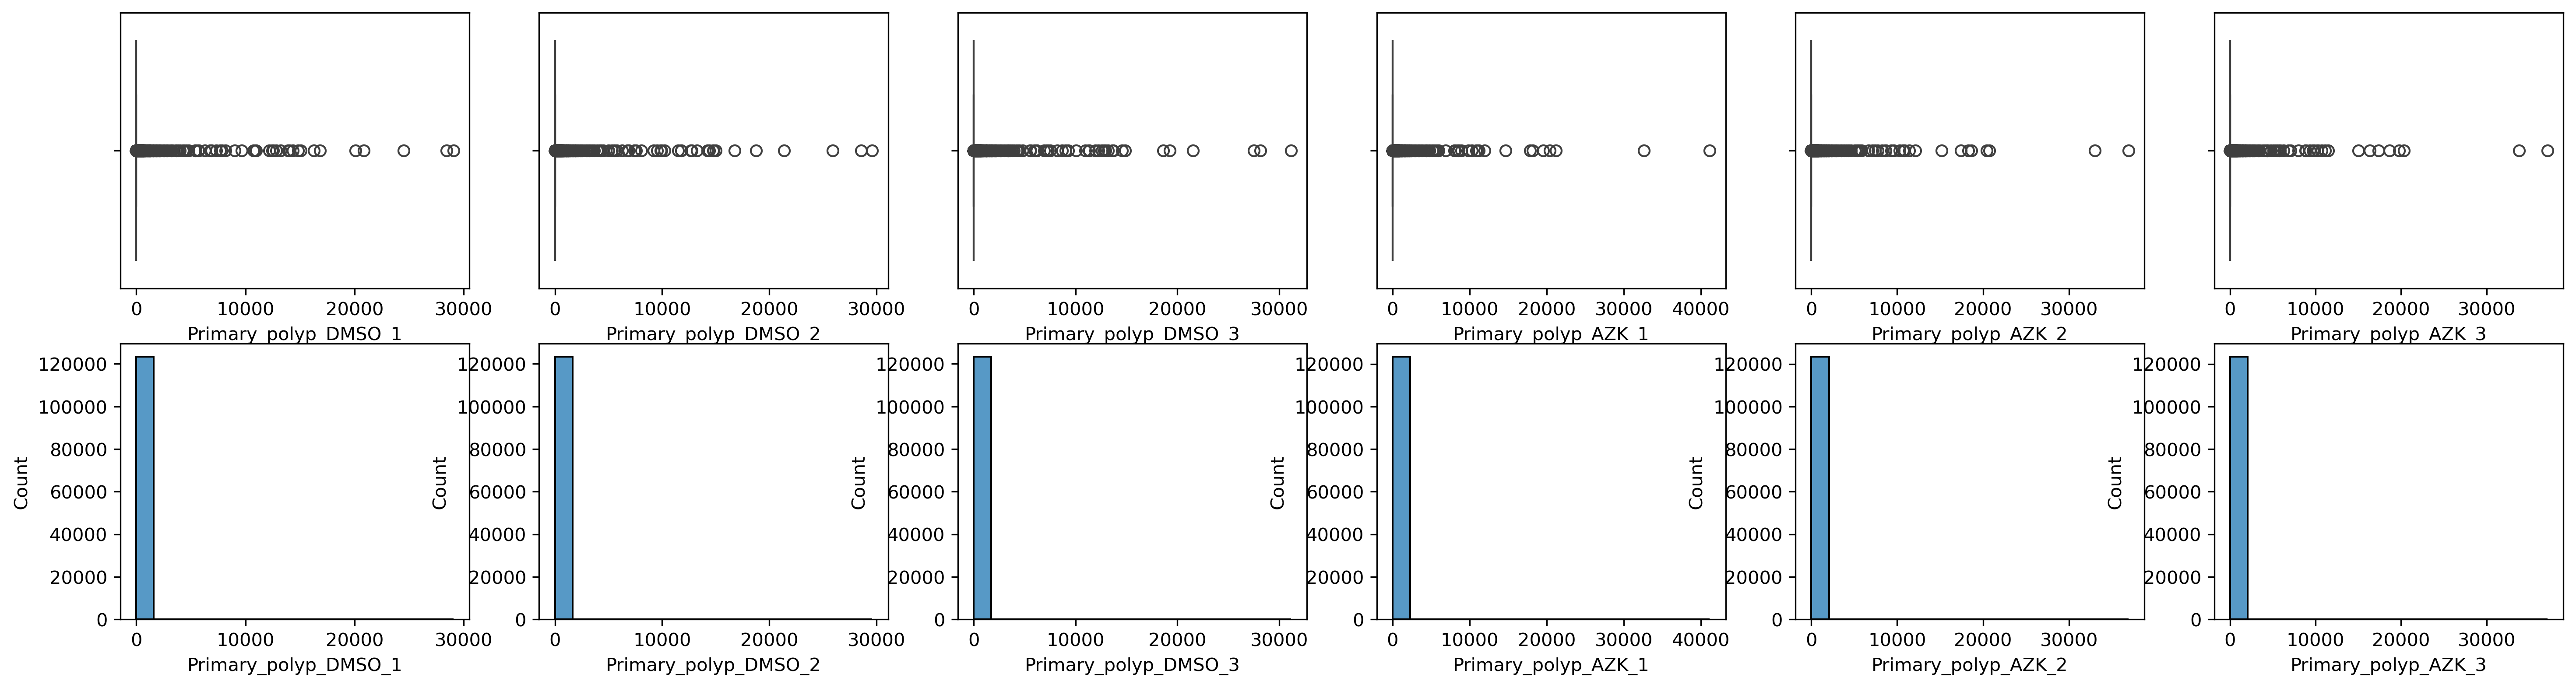

3) NA values:
- Total NA count is 0 in 0 rows.
- Following columns contain NA: ()

Dataframe contains 110817 duplicates.


f:\Documents\Bioinformatics Institute\Semester_project\code_\EDA.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


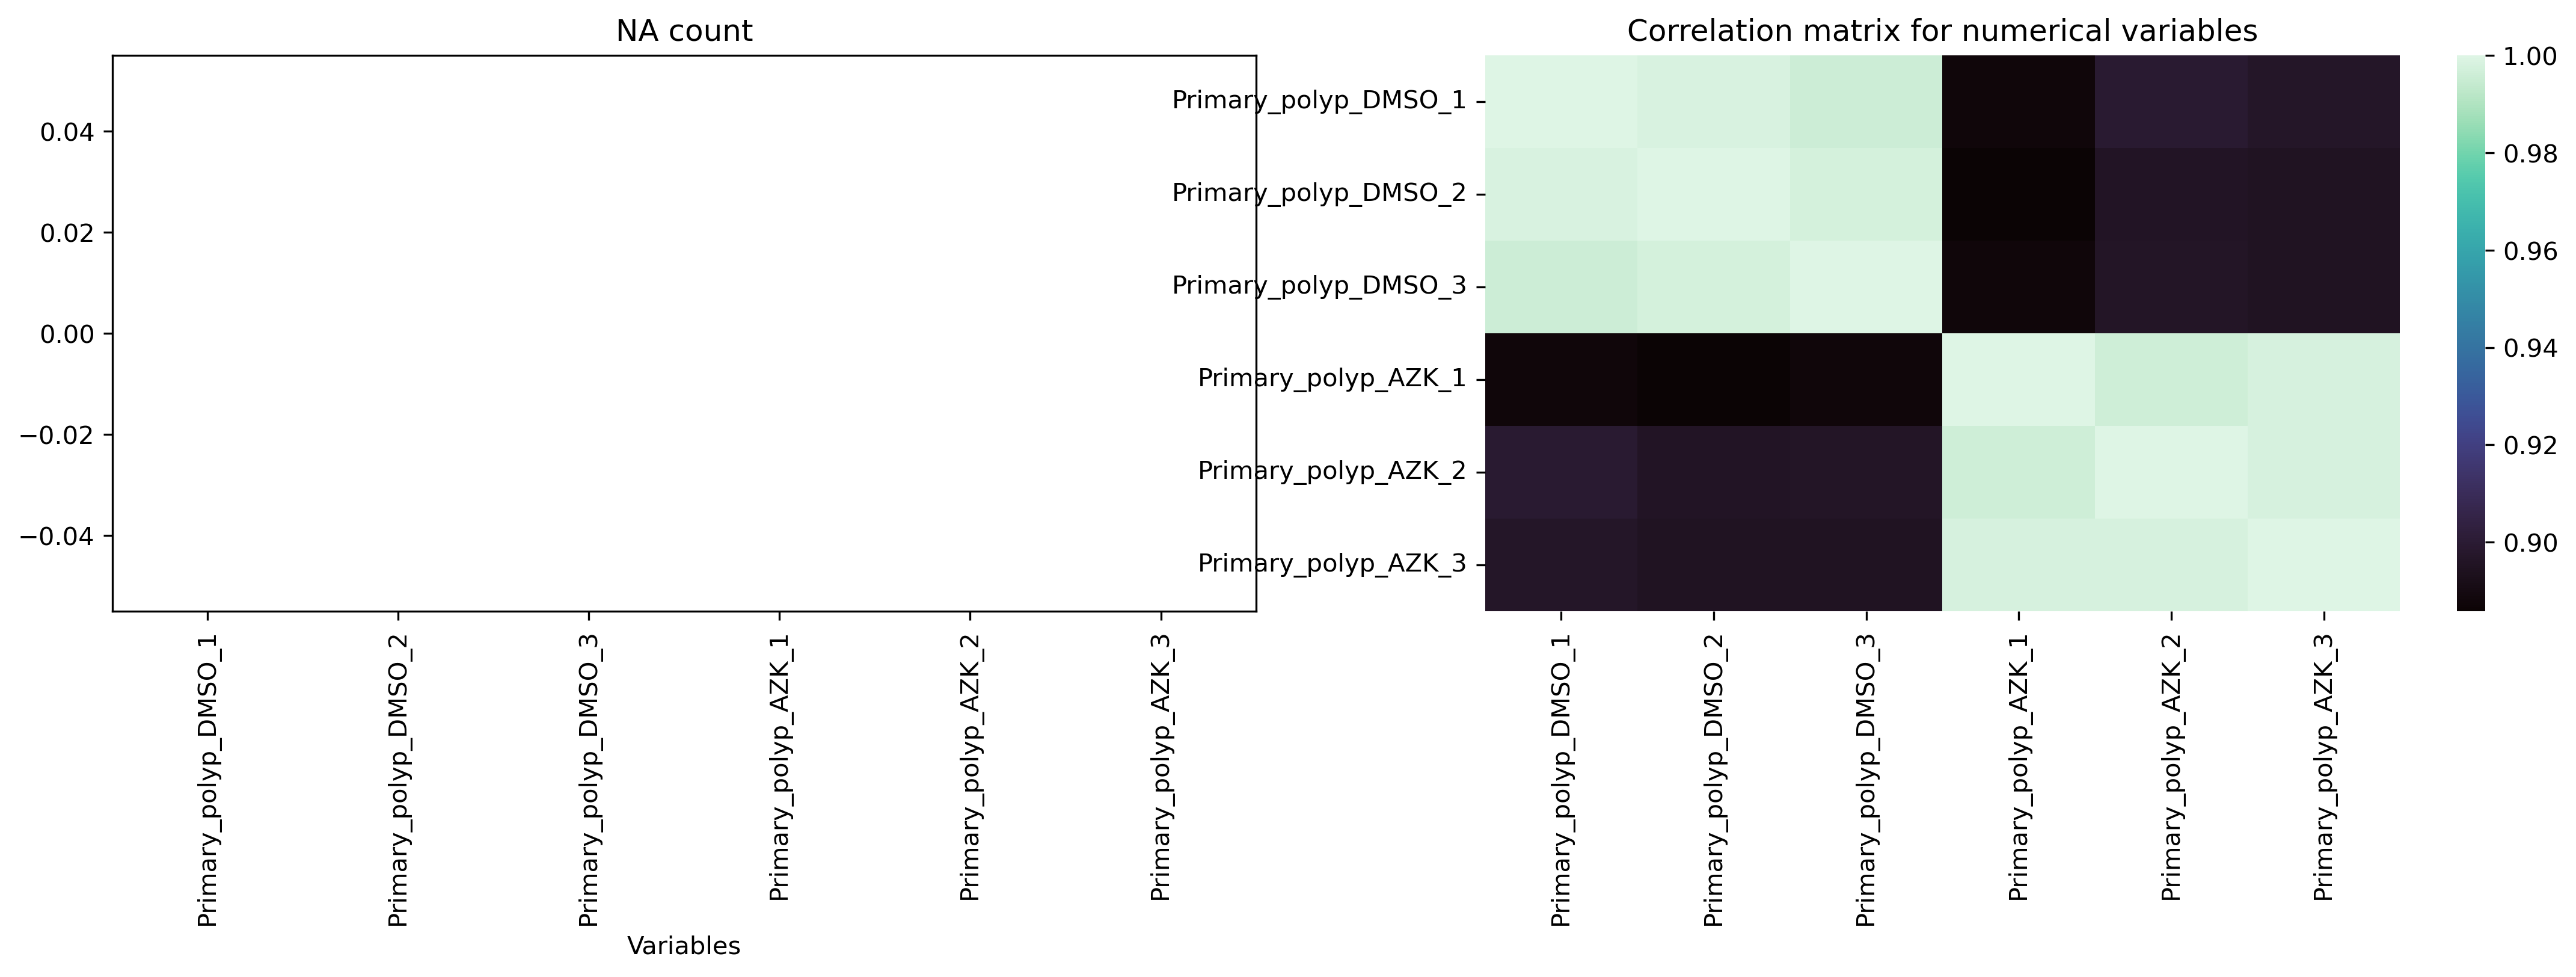

In [5]:
run_eda(kallisto_matrix)

##  5. Differential expression analysis

*   `DESeq2`
*   `EdgeR`
*   `sleuth`

[Отличия](https://www.biostars.org/p/285633/) `sleuth` от `DESeq2`.

### DESeq2

In [ ]:
%%bash
mkdir -p data_folder/processed_data/4.Expression_count/DESeq2/

#### Select control genes for DESeq

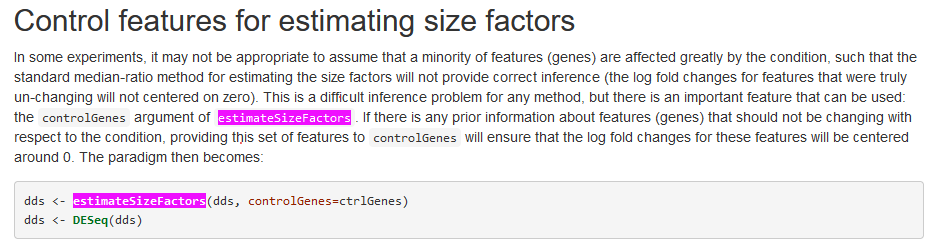

In [47]:
Image('../data_folder/processed_data/4.Expression_count/DESeq2/normalization_DESeq2_control_genes.png')  # https://www.bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#differential-expression-analysis

##### Query GAPDH sequence

In [107]:
Entrez.email = 'd2707bredov@gmail.com'

In [158]:
gapdh_name = 'Dynamena pumila glyceraldehyde 3-phosphate dehydrogenase'
handle = Entrez.esearch(db='nucleotide', term=gapdh_name)
stream = Entrez.efetch(db='nucleotide', id=Entrez.read(handle)['IdList'][0], retmode='text', rettype='gb')
gapdh_record = SeqIO.read(stream, "genbank")
stream.close()

In [159]:
gapdh_record

SeqRecord(seq=Seq('AAAGATAAAAATGGTGAAAATAGGTATTAACGGATTTGGCCGTATTGGAAGATT...AAA'), id='MK005879.1', name='MK005879', description='Dynamena pumila glyceraldehyde 3-phosphate dehydrogenase mRNA, partial cds', dbxrefs=[])

In [115]:
with open('../data_folder/raw_data/GAPDH.fasta', mode='w+') as control_genes_fasta:
    control_genes_fasta.write(f'>{gapdh_record.id} {gapdh_record.description}\n')
    control_genes_fasta.write(f'{gapdh_record.seq}\n')
    control_genes_fasta.write('\n')

##### Align to reference

In [ ]:
%%bash
cd data_folder/processed_data/bwa_res
bwa index ../../raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta
bwa mem -a -t 8 ../../raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta ../../raw_data/GAPDH.fasta 2> alignment.log | samtools view -S -b - | tee alignment_unsorted.bam | samtools flagstat - &> samtools.log

samtools sort alignment_unsorted.bam -o alignment_sorted.bam
samtools index alignment_sorted.bam

In [132]:
%%bash
samtools view ../data_folder/processed_data/bwa_res/alignment_sorted.bam | cut -f3 > ../data_folder/processed_data/bwa_res/GAPDH_nodes.txt

In [133]:
with open('../data_folder/processed_data/bwa_res/GAPDH_nodes.txt') as gapdh_nodes_file:
    gapdh_nodes = [node.strip() for node in gapdh_nodes_file.readlines()]
kallisto_matrix.loc[gapdh_nodes,:]

,Primary_polyp_DMSO_1,Primary_polyp_DMSO_2,Primary_polyp_DMSO_3,Primary_polyp_AZK_1,Primary_polyp_AZK_2,Primary_polyp_AZK_3
target_id,,,,,,
NODE_7862_length_4572_cov_282.519099_g1855_i0,6,6,4,5,6,6
NODE_27786_length_2344_cov_497.751412_g1855_i2,0,0,0,0,0,0
NODE_28546_length_2298_cov_511.724169_g1855_i3,0,0,0,0,0,0
NODE_33787_length_1995_cov_585.320697_g1855_i4,0,0,0,0,0,0
NODE_34592_length_1952_cov_597.286014_g1855_i5,0,0,0,0,0,0
NODE_34790_length_1941_cov_602.326660_g1855_i6,5,3,4,1,0,3
NODE_35809_length_1886_cov_615.371677_g1855_i7,201,219,203,85,88,92


In [156]:
gapdh_records = []
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        if gene.rec_id in gapdh_nodes:
            gapdh_records.append(gene)
        if len(gapdh_records) == len(gapdh_nodes):
            break

In [160]:
with open('../data_folder/processed_data/control_genes_fasta.fasta', mode='w+') as control_genes_fasta:
    for record in gapdh_records:
        control_genes_fasta.write(f'>{record.rec_id} {record.rec_desc}\n')
        control_genes_fasta.write(f'{record.rec_seq}\n')
        control_genes_fasta.write('\n')
    control_genes_fasta.write(f'>{gapdh_record.id} {gapdh_record.description}\n')
    control_genes_fasta.write(f'{gapdh_record.seq}\n')
    control_genes_fasta.write('\n')

#### Run DESeq

##### Without control gene

In [141]:
%%R
deseq2_workflow <- function(file){
    # Set up the conditions based on the experimental setup.
    cond_1 = rep("DMSO", 3)
    cond_2 = rep("AZK", 3)

    # Read the data from the standard input.
    countData = read.table(file, header=TRUE, sep="\t", row.names=1)

    # Build the dataframe from the conditions
    samples = names(countData)
    condition = factor(c(cond_1, cond_2))
    colData = data.frame(samples=samples, condition=condition)

    # Create DESEq2 dataset.
    dds = DESeqDataSetFromMatrix(countData=countData, colData=colData, design = ~condition)

    #Set the reference to be compared
    dds$condition = relevel(dds$condition,"DMSO")

    # Run deseq
    dds = DESeq(dds)

    # Format the results.
    res = results(dds)

    # Sort the results data frame by the padj and foldChange columns.
    sorted = res[with(res, order(padj, -log2FoldChange)), ]

    # Turn it into a dataframe to have proper column names.
    sorted.df = data.frame("id"=rownames(sorted),sorted)

    # Write the table out.
    write.table(sorted.df, file="../data_folder/processed_data/4.Expression_count/DESeq2/result.txt", sep="\t", col.names=NA, quote=FALSE)

    # Get normalized counts and write this to a file
    nc = counts(dds,normalized=TRUE)

    # Turn it into a dataframe to have proper column names.
    dt = data.frame("id"=rownames(nc),nc)

    # Save the normalize data matrix.
    write.table(dt, file="../data_folder/processed_data/4.Expression_count/DESeq2/norm-matrix-deseq2.txt", sep="\t",  row.name=FALSE, col.names=TRUE,quote=FALSE)
}

##### With control gene

In [144]:
%%R
deseq2_workflow_ctrl <- function(file){
    # Set up the conditions based on the experimental setup.
    cond_1 = rep("DMSO", 3)
    cond_2 = rep("AZK", 3)

    # Read the data from the standard input.
    countData = read.table(file, header=TRUE, sep="\t", row.names=1)

    # Build the dataframe from the conditions
    samples = names(countData)
    condition = factor(c(cond_1, cond_2))
    colData = data.frame(samples=samples, condition=condition)

    # Create DESEq2 dataset.
    dds = DESeqDataSetFromMatrix(countData=countData, colData=colData, design = ~condition)

    #Set the reference to be compared
    dds$condition = relevel(dds$condition,"DMSO")

    # # Control features for estimating size factors (normalize counts)
    ctrlGenes <- c(which(rownames(countData) == "NODE_35809_length_1886_cov_615.371677_g1855_i7"))
    dds <- estimateSizeFactors(dds, controlGenes=ctrlGenes)

    # Run deseq
    dds = DESeq(dds)

    # Format the results.
    res = results(dds)

    # Sort the results data frame by the padj and foldChange columns.
    sorted = res[with(res, order(padj, -log2FoldChange)), ]

    # Turn it into a dataframe to have proper column names.
    sorted.df = data.frame("id"=rownames(sorted),sorted)

    # Write the table out.
    write.table(sorted.df, file="../data_folder/processed_data/4.Expression_count/DESeq2/result_ctrl.txt", sep="\t", col.names=NA, quote=FALSE)

    # Get normalized counts and write this to a file
    nc = counts(dds,normalized=TRUE)

    # Turn it into a dataframe to have proper column names.
    dt = data.frame("id"=rownames(nc),nc)

    # Save the normalize data matrix.
    write.table(dt, file="../data_folder/processed_data/4.Expression_count/DESeq2/norm-matrix-deseq2_ctrl.txt", sep="\t",  row.name=FALSE, col.names=TRUE,quote=FALSE)
}

#### Save results

In [142]:
%%R
file <- "../data_folder/processed_data/4.Expression_count/kallisto/count_martix.txt"
deseq2_workflow(file)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [145]:
%%R
file <- "../data_folder/processed_data/4.Expression_count/kallisto/count_martix.txt"
deseq2_workflow_ctrl(file)

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates



R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



#### Take a look at results

##### Without control gene.

In [146]:
deseq_results = pd.read_table('../data_folder/processed_data/4.Expression_count/DESeq2/result.txt', header = 0, sep='\t', index_col=0)

In [147]:
deseq_results

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_69856_length_604_cov_410.035651_g26341_i0,NODE_69856_length_604_cov_410.035651_g26341_i0,719.26,-4.60,0.15,-30.75,0.00,0.00
NODE_60660_length_861_cov_520.463325_g17614_i1,NODE_60660_length_861_cov_520.463325_g17614_i1,778.71,-3.71,0.13,-29.39,0.00,0.00
NODE_33125_length_2030_cov_1007.464519_g8431_i1,NODE_33125_length_2030_cov_1007.464519_g8431_i1,"9,605.42",-1.93,0.07,-28.55,0.00,0.00
NODE_70396_length_592_cov_1334.981785_g26828_i0,NODE_70396_length_592_cov_1334.981785_g26828_i0,"3,695.34",-2.15,0.08,-28.17,0.00,0.00
NODE_55400_length_1040_cov_442.222668_g16580_i0,NODE_55400_length_1040_cov_442.222668_g16580_i0,"2,392.31",-2.21,0.08,-27.17,0.00,0.00
...,...,...,...,...,...,...,...
NODE_123441_length_158_cov_2.069565_g79460_i0,NODE_123441_length_158_cov_2.069565_g79460_i0,0.00,NaN,NaN,NaN,NaN,NaN
NODE_123442_length_158_cov_2.017391_g79461_i0,NODE_123442_length_158_cov_2.017391_g79461_i0,0.00,NaN,NaN,NaN,NaN,NaN
NODE_123443_length_158_cov_1.217391_g79462_i0,NODE_123443_length_158_cov_1.217391_g79462_i0,0.00,NaN,NaN,NaN,NaN,NaN
NODE_123444_length_158_cov_1.156522_g79463_i0,NODE_123444_length_158_cov_1.156522_g79463_i0,0.00,NaN,NaN,NaN,NaN,NaN


In [148]:
deseq_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123445 entries, NODE_69856_length_604_cov_410.035651_g26341_i0 to NODE_123445_length_144_cov_13.989305_g79464_i0
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              123445 non-null  object 
 1   baseMean        123445 non-null  float64
 2   log2FoldChange  32313 non-null   float64
 3   lfcSE           32313 non-null   float64
 4   stat            32313 non-null   float64
 5   pvalue          32311 non-null   float64
 6   padj            12614 non-null   float64
dtypes: float64(6), object(1)
memory usage: 7.5+ MB


Check for `NA`:

In [149]:
deseq_results.query('padj < 0.05').info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, NODE_69856_length_604_cov_410.035651_g26341_i0 to NODE_45110_length_1452_cov_542.810504_g11191_i1
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1050 non-null   object 
 1   baseMean        1050 non-null   float64
 2   log2FoldChange  1050 non-null   float64
 3   lfcSE           1050 non-null   float64
 4   stat            1050 non-null   float64
 5   pvalue          1050 non-null   float64
 6   padj            1050 non-null   float64
dtypes: float64(6), object(1)
memory usage: 65.6+ KB


Thus, we got $123445$ differentially expressed genes, $1050$ of them have adjusted p-value lesser than $0.05$.

In [150]:
all(deseq_results.query('padj < 0.05').index == deseq_results.head(1050).index)

True

##### With control gene.

In [151]:
deseq_results_ctrl = pd.read_table('../data_folder/processed_data/4.Expression_count/DESeq2/result_ctrl.txt', header = 0, sep='\t', index_col=0)

In [135]:
deseq_results_ctrl.head()

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_61938_length_821_cov_78.356041_g20323_i0,NODE_61938_length_821_cov_78.356041_g20323_i0,"1,174.99",4.72,0.12,37.93,0.00,0.00
NODE_54812_length_1061_cov_16.372299_g16298_i0,NODE_54812_length_1061_cov_16.372299_g16298_i0,"2,100.13",2.69,0.09,29.83,0.00,0.00
NODE_67158_length_672_cov_9.523052_g24107_i0,NODE_67158_length_672_cov_9.523052_g24107_i0,"1,832.80",2.73,0.10,28.06,0.00,0.00
NODE_60533_length_865_cov_411.037713_g19428_i0,NODE_60533_length_865_cov_411.037713_g19428_i0,"8,159.71",2.25,0.08,27.66,0.00,0.00
NODE_76400_length_474_cov_168.814385_g32489_i0,NODE_76400_length_474_cov_168.814385_g32489_i0,"3,121.43",2.35,0.09,26.57,0.00,0.00


In [136]:
deseq_results_ctrl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123445 entries, NODE_61938_length_821_cov_78.356041_g20323_i0 to NODE_123445_length_144_cov_13.989305_g79464_i0
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              123445 non-null  object 
 1   baseMean        123445 non-null  float64
 2   log2FoldChange  32313 non-null   float64
 3   lfcSE           32313 non-null   float64
 4   stat            32313 non-null   float64
 5   pvalue          32311 non-null   float64
 6   padj            16308 non-null   float64
dtypes: float64(6), object(1)
memory usage: 7.5+ MB


Check for `NA`:

In [137]:
deseq_results_ctrl.query('padj < 0.05').info()

<class 'pandas.core.frame.DataFrame'>
Index: 5196 entries, NODE_61938_length_821_cov_78.356041_g20323_i0 to NODE_53553_length_1107_cov_335.498120_g15137_i1
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5196 non-null   object 
 1   baseMean        5196 non-null   float64
 2   log2FoldChange  5196 non-null   float64
 3   lfcSE           5196 non-null   float64
 4   stat            5196 non-null   float64
 5   pvalue          5196 non-null   float64
 6   padj            5196 non-null   float64
dtypes: float64(6), object(1)
memory usage: 324.8+ KB


Thus, we got $123445$ differentially expressed genes, $5196$ of them have adjusted p-value lesser than $0.05$.

In [161]:
all(deseq_results_ctrl.query('padj < 0.05').index == deseq_results_ctrl.head(5196).index)

True

#### Draw clustermap

In [ ]:
meta = pd.DataFrame({'Primary_polyp_DMSO_1': ('DMSO', 1),
                     'Primary_polyp_DMSO_2': ('DMSO', 2),
                     'Primary_polyp_DMSO_3': ('DMSO', 3),
                     'Primary_polyp_AZK_1': ('AZK', 1), 
                     'Primary_polyp_AZK_2': ('AZK', 2),
                     'Primary_polyp_AZK_3': ('AZK', 3),}, index=['Sample', 'Replicate']).T

In [ ]:
col_colors = meta['Sample'].map({'AZK': '#7247D7', 'DMSO': '#8D6DD7'})
col_colors.name = 'Sample'
rep_colors = meta['Replicate'].map({1: '#0099CC', 2: '#666BFF', 3: '#66CCFF'})
rep_colors.name = 'Replicate'
col_colors = pd.concat([col_colors, rep_colors], axis=1)

##### Without control gene.

###### Identify 100 transcripts with most remarkable changes in expression

In [180]:
deseq_results_100 = deseq_results.head(100)
kallisto_matrix_100 = kallisto_matrix.loc[deseq_results_100.index]


In [181]:
deseq_results_100.to_csv('../data_folder/processed_data/4.Expression_count/DESeq2/result_100.txt', sep='\t')
kallisto_matrix_100.to_csv('../data_folder/processed_data/4.Expression_count/kallisto/count_martix_100.txt', sep='\t')

###### Draw heatmap

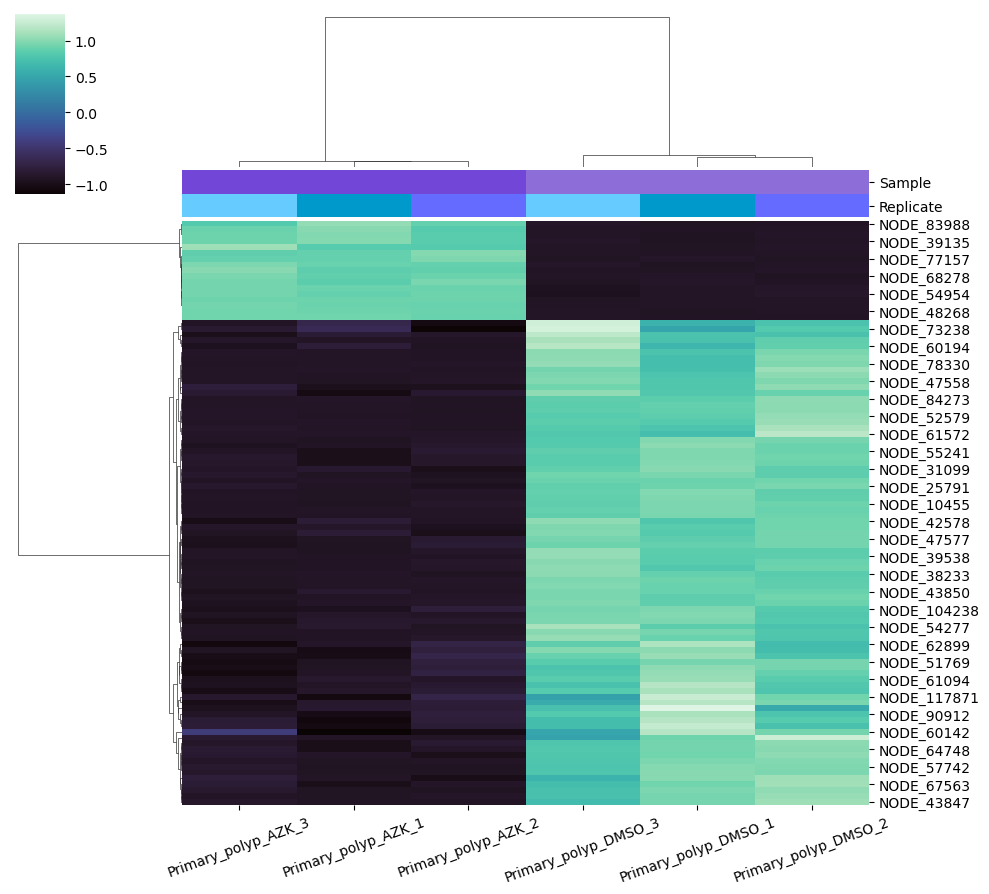

In [ ]:
kallisto_cluster_df = kallisto_matrix_100.set_index(kallisto_matrix_100.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster = sns.clustermap(kallisto_cluster_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/kallisto_matrix_100.png', dpi=300)
None

##### With control gene.

###### Identify 100 transcripts with most remarkable changes in expression

In [ ]:
deseq_results_ctrl_100 = deseq_results_ctrl.head(100)
kallisto_matrix_ctrl_100 = kallisto_matrix.loc[deseq_results_ctrl_100.index]


In [ ]:
deseq_results_ctrl_100.to_csv('../data_folder/processed_data/4.Expression_count/DESeq2/result_ctrl_100.txt', sep='\t')
kallisto_matrix_ctrl_100.to_csv('../data_folder/processed_data/4.Expression_count/kallisto/count_martix_ctrl_100.txt', sep='\t')

###### Draw heatmap

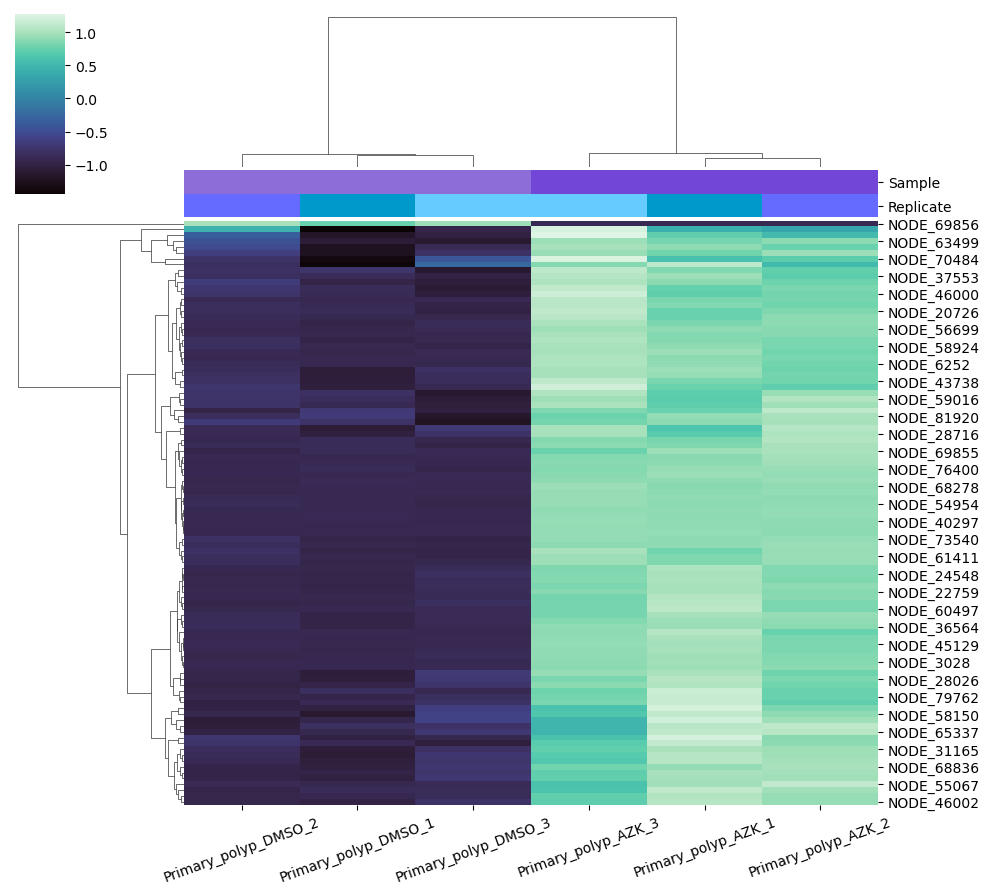

In [182]:
kallisto_ctrl_cluster_df = kallisto_matrix_ctrl_100.set_index(kallisto_matrix_ctrl_100.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster = sns.clustermap(kallisto_ctrl_cluster_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4.Expression_count/kallisto/kallisto_matrix_ctrl_100.png', dpi=300)
None

## 6. Identify 100 transcripts with most remarkable changes in expression

### 6.1 Drag sequencies from reference

#### `OpenFasta`

In [84]:
fasta_records = []
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        if gene.rec_id in deseq_results_100.index:
            fasta_records.append(gene)
        if len(fasta_records) == len(deseq_results_100.index):
            break

##### Check

In [85]:
records = SeqIO.parse('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta', 'fasta')  # https://biopython.org/wiki/SeqIO
fasta_records_seqio = []
for record in records:
    if record.id in deseq_results_100.index:
            fasta_records_seqio.append(record)
    if len(fasta_records_seqio) == len(deseq_results_100.index):
        break

In [86]:
fasta_check = []
for (fasta_seqio, fasta_openfasta) in zip(fasta_records_seqio, fasta_records):
    fasta_check.append(str(fasta_seqio.seq) == fasta_openfasta.rec_seq)

print(all(fasta_check))

True


### 6.2 Write sequencies to file

In [ ]:
%%bash
mkdir -p data_folder/processed_data/6.Identify_100/kegg

In [57]:
with open('../data_folder/processed_data/6.Identify_100/results_100_seqs.fasta', mode='w+') as results_100_seqs:
    for fasta in fasta_records:
        results_100_seqs.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        results_100_seqs.write(f'{fasta.rec_seq}\n')
        results_100_seqs.write('\n')

### 6.3 BLAST sequencies

BLAST:

*   `tblastx`
*   Cnidaria (taxid:6073)

kegg:

*   https://www.genome.jp/tools/kofamkoala/

In [59]:
def read_kegg_file(file):
    with open(file) as kegg_table:
        header = [[]]
        for char_header, char_sep in zip(kegg_table.readline().lstrip(), kegg_table.readline().lstrip()):
            if char_sep == '-':
                header[-1].append(char_header)
            elif char_sep == ' ':
                header[-1] = ''.join(header[-1]).strip()
                header.append([])
        header[-1] = ''.join(header[-1]).strip()
        
        results = []
        for line in kegg_table:
            results.append(line.strip().split(None, len(header)-1))
        
        return pd.DataFrame(results, columns=header)#.set_index(header[0])

In [96]:
results_100_kegg = read_kegg_file('../data_folder/processed_data/6.Identify_100/kegg/result_all.txt')

In [101]:
results_100_kegg.head(15)

,gene name,KO,thrshld,score,E-value,KO definition
0,NODE_10455_length_4045_cov_509.713393_g10_i2982_1,K24835,149.93,147.5,1.8e-44,glioma pathogenesis-related protein 2
1,NODE_10455_length_4045_cov_509.713393_g10_i2982_1,K13449,155.13,89.1,1e-26,pathogenesis-related protein 1
2,NODE_10455_length_4045_cov_509.713393_g10_i2982_1,K19919,197.60,61.4,2.5e-18,cysteine-rich secretory protein 1/2/3
3,NODE_10455_length_4045_cov_509.713393_g10_i2982_1,K24834,263.33,54.5,3.5e-16,glioma pathogenesis-related protein 1
4,NODE_10455_length_4045_cov_509.713393_g10_i2982_1,K24836,392.87,48.8,1.9e-14,peptidase inhibitor 15
5,NODE_10455_length_4045_cov_509.713393_g10_i2982_2,K24835,149.93,90.0,5.3e-27,glioma pathogenesis-related protein 2
6,NODE_10455_length_4045_cov_509.713393_g10_i2982_2,K13449,155.13,56.9,7.3e-17,pathogenesis-related protein 1
7,NODE_10455_length_4045_cov_509.713393_g10_i2982_2,K24834,263.33,42.7,1.3e-12,glioma pathogenesis-related protein 1
8,NODE_10455_length_4045_cov_509.713393_g10_i2982_2,K19919,197.60,37.3,5.2e-11,cysteine-rich secretory protein 1/2/3
9,NODE_10455_length_4045_cov_509.713393_g10_i2982_2,K22682,308.07,31.6,2.5e-09,c-type lectin domain family 18


In [102]:
results_100_kegg_group = pd.DataFrame(results_100_kegg[['KO definition', 'gene name']].groupby('KO definition')['gene name'].apply(list)).reset_index()
results_100_kegg_group['counts'] = results_100_kegg_group['gene name'].apply(len)
results_100_kegg_group = results_100_kegg_group.sort_values(by='counts', ascending=False).drop(0)


In [103]:
results_100_kegg_group.head(30)

,KO definition,gene name,counts
619,collagen type IV alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,25
635,collagen type XXI alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,23
636,collagen type XXII alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,21
1032,macrophage receptor with collagenous structure,[NODE_24058_length_2598_cov_603.844618_g5029_i...,21
625,collagen type X alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,20
651,complement C1q subcomponent subunit C,[NODE_24058_length_2598_cov_603.844618_g5029_i...,20
1285,otolin-1,[NODE_24058_length_2598_cov_603.844618_g5029_i...,19
617,collagen type II alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,19
622,collagen type VI alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,18
632,collagen type XVII alpha,[NODE_24058_length_2598_cov_603.844618_g5029_i...,17


In [108]:
results_100_kegg_group.to_csv('../data_folder/processed_data/6.Identify_100/kegg/result_100_all_grouped.txt', sep='\t')

In [109]:
results_kegg_KOd_counts = pd.DataFrame(results_100_kegg['KO definition'].value_counts().drop('-')).reset_index()

In [110]:
results_kegg_KOd_counts.head(15)

,KO definition,count
0,collagen type IV alpha,25
1,collagen type XXI alpha,23
2,collagen type XXII alpha,21
3,macrophage receptor with collagenous structure,21
4,collagen type X alpha,20
5,complement C1q subcomponent subunit C,20
6,collagen type II alpha,19
7,otolin-1,19
8,collagen type VI alpha,18
9,"collagen type V/XI/XXIV/XXVII, alpha",17


In [67]:
search_target = ['Notch', 'protein delta']
results_kegg_KOd_counts[results_kegg_KOd_counts['KO definition'].str.contains('|'.join(search_target))]

,KO definition,count
141,Notch 1,5
166,Notch 4,4
173,protein delta homolog 2,4
176,delta and Notch-like epidermal growth factor-r...,4
177,protein delta homolog 1,4
178,Notch homolog 2 N-terminal-like protein,4
235,Notch 3,4
236,Notch 2,4


In [34]:
results_kegg_KOd_counts.to_csv('../data_folder/processed_data/5. BLAST/result_all_KOd_counts.txt', sep='\t')

#### Примечания

##### 1. [Список](https://ncbi.github.io/blast-cloud/blastdb/available-blastdbs.html) баз данных. `# https://stackoverflow.com/a/29496260`

##### 2. Запросы через сайт NCBI обрабатываются в приоритете:

[Usage Guidelines](https://blast.ncbi.nlm.nih.gov/doc/blast-help/developerinfo.html#usage-guidelines)

The NCBI BLAST servers are a shared resource. We give priority to interactive users. In order to ensure availability of the service to the entire community, we may limit searches for some high volume users. Interactive users of the NCBI webpages through a web browser should not encounter problems. We will move searches of users who submit more than 100 searches in a 24 hour period to a slower queue, or, in extreme cases, will block the requests. To avoid problems, API users should comply with the following guidelines:

*   Do not contact the server more often than once every 10 seconds.

*   Do not poll for any single RID more often than once a minute.

*   Use the URL parameter email and tool, so that the NCBI can contact you if there is a problem.

*   Run scripts weekends or between 9 pm and 5 am Eastern time on weekdays if more than 50 searches will be submitted.

BLAST often runs more efficiently if multiple queries are sent as one search rather than if each query is sent as an individual search. This is especially true for blastn, megablast, and tblastn. If your queries are short (less than a few hundred bases) we suggest you merge them into one search of up to 1,000 bases

The NCBI servers are a shared resource and not intended for projects that involve a large number of BLAST searches. We provide the Stand-alone BLAST+ binaries, Docker Image and Elastic BLAST for these purposes.

## 7. Identify 100 transcripts with most remarkable upregulation and 100 transcripts with most remarkable downregulation in expression

In [171]:
deseq_results_lfc_neg = deseq_results.query('padj < 0.05 and log2FoldChange < 0').sort_values(by='log2FoldChange')
deseq_results_lfc_pos = deseq_results.query('padj < 0.05 and log2FoldChange > 0').sort_values(by='log2FoldChange', ascending=False)

In [173]:
deseq_results_lfc_pos.head(100)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_30129_length_2202_cov_506.623437_g10_i7576,NODE_30129_length_2202_cov_506.623437_g10_i7576,47.35,8.86,1.23,7.23,0.00,0.00
NODE_25561_length_2490_cov_379.813241_g2076_i4,NODE_25561_length_2490_cov_379.813241_g2076_i4,24.18,7.89,1.27,6.22,0.00,0.00
NODE_14439_length_3485_cov_425.093260_g10_i4025,NODE_14439_length_3485_cov_425.093260_g10_i4025,16.58,7.35,1.31,5.61,0.00,0.00
NODE_82667_length_385_cov_348.511696_g38695_i0,NODE_82667_length_385_cov_348.511696_g38695_i0,15.68,7.27,1.32,5.51,0.00,0.00
NODE_35799_length_1887_cov_172.728308_g10_i8617,NODE_35799_length_1887_cov_172.728308_g10_i8617,10.84,6.73,1.37,4.90,0.00,0.00
...,...,...,...,...,...,...,...
NODE_73420_length_529_cov_270.102881_g29610_i0,NODE_73420_length_529_cov_270.102881_g29610_i0,7.97,3.74,1.14,3.29,0.00,0.01
NODE_766_length_9889_cov_111.624213_g162_i0,NODE_766_length_9889_cov_111.624213_g162_i0,7.97,3.74,1.14,3.29,0.00,0.01
NODE_72101_length_554_cov_212.422701_g28379_i0,NODE_72101_length_554_cov_212.422701_g28379_i0,7.84,3.72,1.14,3.25,0.00,0.02
NODE_75062_length_499_cov_138.337719_g31175_i0,NODE_75062_length_499_cov_138.337719_g31175_i0,7.82,3.71,1.14,3.26,0.00,0.02


In [174]:
deseq_results_lfc_neg.head(100)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_41200_length_1625_cov_455.115044_g10_i9542,NODE_41200_length_1625_cov_455.115044_g10_i9542,21.59,-8.04,1.28,-6.27,0.00,0.00
NODE_75630_length_487_cov_299.308559_g31728_i0,NODE_75630_length_487_cov_299.308559_g31728_i0,41.86,-8.03,1.24,-6.49,0.00,0.00
NODE_118564_length_177_cov_4.052239_g74583_i0,NODE_118564_length_177_cov_4.052239_g74583_i0,15.15,-7.53,1.33,-5.65,0.00,0.00
NODE_65404_length_717_cov_420.952522_g22751_i0,NODE_65404_length_717_cov_420.952522_g22751_i0,46.49,-7.28,1.08,-6.76,0.00,0.00
NODE_72911_length_539_cov_12.485887_g29128_i0,NODE_72911_length_539_cov_12.485887_g29128_i0,12.20,-7.22,1.36,-5.31,0.00,0.00
...,...,...,...,...,...,...,...
NODE_69856_length_604_cov_410.035651_g26341_i0,NODE_69856_length_604_cov_410.035651_g26341_i0,719.26,-4.60,0.15,-30.75,0.00,0.00
NODE_84735_length_362_cov_267.520376_g40757_i0,NODE_84735_length_362_cov_267.520376_g40757_i0,21.76,-4.55,0.76,-5.97,0.00,0.00
NODE_50117_length_1245_cov_482.574043_g2153_i27,NODE_50117_length_1245_cov_482.574043_g2153_i27,23.58,-4.44,0.72,-6.19,0.00,0.00
NODE_54024_length_1089_cov_591.498088_g10_i11390,NODE_54024_length_1089_cov_591.498088_g10_i11390,53.19,-4.42,0.48,-9.20,0.00,0.00


In [ ]:
deseq_results_ctrl_lfc_neg = deseq_results_ctrl.query('padj < 0.05 and log2FoldChange < 0').sort_values(by='log2FoldChange')
deseq_results_ctrl_lfc_pos = deseq_results_ctrl.query('padj < 0.05 and log2FoldChange > 0').sort_values(by='log2FoldChange', ascending=False)

In [176]:
deseq_results_ctrl_lfc_neg.head(100)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_41200_length_1625_cov_455.115044_g10_i9542,NODE_41200_length_1625_cov_455.115044_g10_i9542,12.71,-6.49,1.36,-4.79,0.00,0.00
NODE_75630_length_487_cov_299.308559_g31728_i0,NODE_75630_length_487_cov_299.308559_g31728_i0,24.84,-6.48,1.28,-5.08,0.00,0.00
NODE_118564_length_177_cov_4.052239_g74583_i0,NODE_118564_length_177_cov_4.052239_g74583_i0,8.94,-5.99,1.43,-4.17,0.00,0.00
NODE_65404_length_717_cov_420.952522_g22751_i0,NODE_65404_length_717_cov_420.952522_g22751_i0,27.74,-5.73,1.11,-5.14,0.00,0.00
NODE_72911_length_539_cov_12.485887_g29128_i0,NODE_72911_length_539_cov_12.485887_g29128_i0,7.19,-5.67,1.48,-3.83,0.00,0.00
...,...,...,...,...,...,...,...
NODE_54360_length_1076_cov_686.294288_g16046_i0,NODE_54360_length_1076_cov_686.294288_g16046_i0,173.40,-0.92,0.21,-4.40,0.00,0.00
NODE_33124_length_2030_cov_1010.917967_g8431_i0,NODE_33124_length_2030_cov_1010.917967_g8431_i0,190.22,-0.88,0.28,-3.12,0.00,0.01
NODE_24058_length_2598_cov_603.844618_g5029_i3,NODE_24058_length_2598_cov_603.844618_g5029_i3,385.64,-0.85,0.15,-5.79,0.00,0.00
NODE_59419_length_903_cov_451.786047_g16029_i3,NODE_59419_length_903_cov_451.786047_g16029_i3,56.89,-0.84,0.34,-2.44,0.01,0.05


In [177]:
deseq_results_ctrl_lfc_pos.head(100)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_30129_length_2202_cov_506.623437_g10_i7576,NODE_30129_length_2202_cov_506.623437_g10_i7576,81.58,10.41,1.21,8.59,0.00,0.00
NODE_25561_length_2490_cov_379.813241_g2076_i4,NODE_25561_length_2490_cov_379.813241_g2076_i4,41.62,9.44,1.24,7.61,0.00,0.00
NODE_14439_length_3485_cov_425.093260_g10_i4025,NODE_14439_length_3485_cov_425.093260_g10_i4025,28.54,8.89,1.27,7.02,0.00,0.00
NODE_82667_length_385_cov_348.511696_g38695_i0,NODE_82667_length_385_cov_348.511696_g38695_i0,26.97,8.81,1.27,6.92,0.00,0.00
NODE_35799_length_1887_cov_172.728308_g10_i8617,NODE_35799_length_1887_cov_172.728308_g10_i8617,18.69,8.28,1.31,6.32,0.00,0.00
...,...,...,...,...,...,...,...
NODE_14953_length_3425_cov_220.455648_g3615_i0,NODE_14953_length_3425_cov_220.455648_g3615_i0,4.60,6.26,1.65,3.79,0.00,0.00
NODE_33141_length_2030_cov_142.261701_g5824_i2,NODE_33141_length_2030_cov_142.261701_g5824_i2,4.60,6.26,1.65,3.79,0.00,0.00
NODE_53087_length_1124_cov_617.274746_g15437_i0,NODE_53087_length_1124_cov_617.274746_g15437_i0,4.60,6.26,1.66,3.77,0.00,0.00
NODE_64798_length_735_cov_75.622832_g22288_i0,NODE_64798_length_735_cov_75.622832_g22288_i0,9.06,6.26,1.43,4.38,0.00,0.00


### 7.1 Drag sequencies from reference

In [38]:
deseq_lfc_pos_results_100 = deseq_results_lfc_pos.head(100)
deseq_lfc_neg_results_100 = deseq_results_lfc_neg.head(100)
kallisto_matrix_pos_100 = kallisto_matrix.loc[deseq_lfc_pos_results_100.index]
kallisto_matrix_neg_100 = kallisto_matrix.loc[deseq_lfc_neg_results_100.index]

In [ ]:
fasta_records_100_pos, fasta_records_100_neg = [], []
len_100_pos, len_100_neg = len(deseq_lfc_pos_results_100.index), len(deseq_lfc_neg_results_100.index)
with OpenFasta('../data_folder/raw_data/refrence/new_dyn_soft_filtered_transcripts.fasta') as gene_extractor:
    for gene in gene_extractor:
        len_pos, len_neg = len(fasta_records_100_pos), len(fasta_records_100_neg)
        if len_pos < len_100_pos and gene.rec_id in deseq_lfc_pos_results_100.index:
            fasta_records_100_pos.append(gene)
        elif len_neg < len_100_pos and gene.rec_id in deseq_lfc_neg_results_100.index:
            fasta_records_100_neg.append(gene)
        elif len_pos + len_neg == 200:
            break

In [ ]:
print(len(fasta_records_100_pos))
print(len(fasta_records_100_neg))

100
100


#### Draw clustermaps

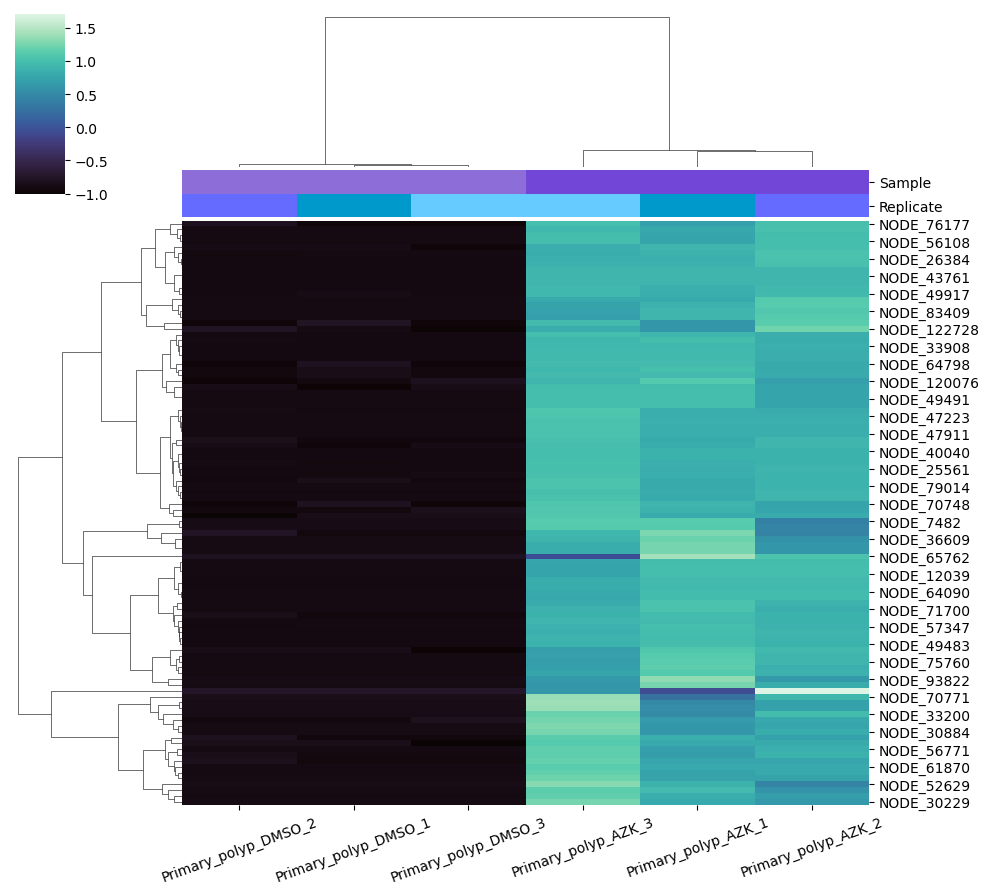

In [41]:
kallisto_cluster_pos_100_df = kallisto_matrix_pos_100.set_index(kallisto_matrix_pos_100.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster_pos_100 = sns.clustermap(kallisto_cluster_pos_100_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster_pos_100.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4. Expression count/kallisto/kallisto_matrix_pos_100.png', dpi=300)
None

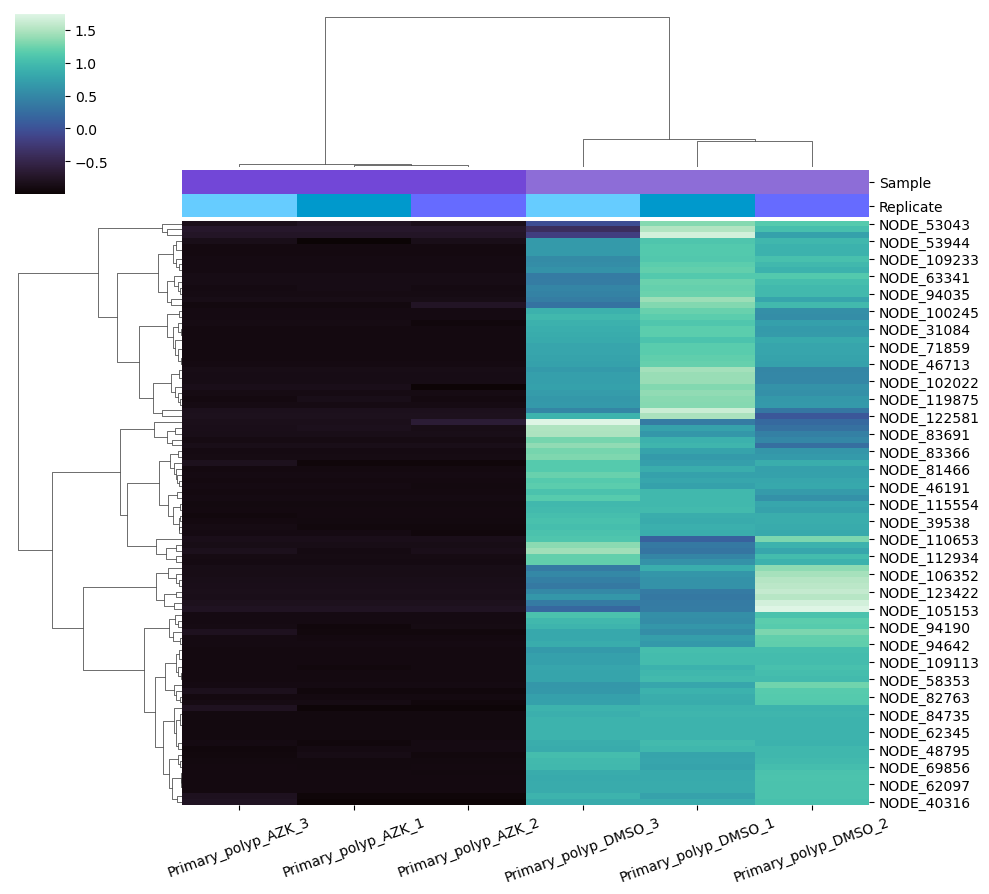

In [42]:
kallisto_cluster_neg_100_df = kallisto_matrix_neg_100.set_index(kallisto_matrix_neg_100.index.str.split('_', n=2).str[:2].str.join('_'))

kallisto_cluster_neg_100 = sns.clustermap(kallisto_cluster_neg_100_df, method='ward', cmap='mako', z_score=0, col_colors=col_colors)
plt.setp(kallisto_cluster_neg_100.ax_heatmap.xaxis.get_majorticklabels(), rotation=20)  # https://stackoverflow.com/a/34697479
plt.savefig('../data_folder/processed_data/4. Expression count/kallisto/kallisto_matrix_neg_100.png', dpi=300)
None

### 7.2 Write sequencies to file

In [ ]:
%%bash
mkdir -p data_folder/processed_data/7.Identify_100and100/pos
mkdir -p data_folder/processed_data/7.Identify_100and100/neg

In [69]:
with open('../data_folder/processed_data/7.Identify_100and100/pos/fasta_100_pos.fasta', mode='w+') as fasta_100_pos:
    for fasta in fasta_records_100_pos:
        fasta_100_pos.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        fasta_100_pos.write(f'{fasta.rec_seq}\n')
        fasta_100_pos.write('\n')

In [70]:
with open('../data_folder/processed_data/7.Identify_100and100/neg/fasta_100_neg.fasta', mode='w+') as fasta_100_neg:
    for fasta in fasta_records_100_neg:
        fasta_100_neg.write(f'>{fasta.rec_id} {fasta.rec_desc}\n')
        fasta_100_neg.write(f'{fasta.rec_seq}\n')
        fasta_100_neg.write('\n')

### 7.3 Convert nucleotide sequencies to protein

In [ ]:
%%bash
TransDecoder.LongOrfs -t data_folder/processed_data//7.Identify_100and100/pos/fasta_100_pos.fasta
mv fasta_100_pos.fasta.transdecoder_dir data_folder/processed_data/7.Identify_100and100/pos

TransDecoder.LongOrfs -t data_folder/processed_data//7.Identify_100and100/neg/fasta_100_neg.fasta
mv fasta_100_neg.fasta.transdecoder_dir data_folder/processed_data/7.Identify_100and100/neg

In [89]:
fasta_100_pos_path = '../data_folder/processed_data/7.Identify_100and100/pos/fasta_100_pos.fasta.transdecoder_dir/longest_orfs.pep'
with OpenFasta(fasta_100_pos_path) as fasta_p:
    print(fasta_p.read_record())

ID: NODE_766_length_9889_cov_111.624213_g162_i0.p1
Description: type:5prime_partial gc:universal NODE_766_length_9889_cov_111.624213_g162_i0:9887-2787(-)
Sequence: LVNATFDTCGEFLIESYAKGRLSSIYTSKVNATVNVICSMGELEVTPTPNEISDGAIEFSKDDTFSLKIRLTTGSFSTYNVSWGDKGLYYFKDQSHLAVPEEFTASYRYGPGNYTVNVTAFTITGGIRTYSVDIRVLLCVVPKVSFNYGSVDAPITYLRADDILFTGTWTFPNPQCKQMIQPKYKFKEWDLQDSKNVSLTAHINNAVKTDDQERNKVTYTIGKLSLPEGNYKLFLYMEYQGVATMYPAFIKIMKSPLVADIVNGVFQTIPFKQLTEDGNRTYYSFTIDGSRSYDPENAEMKTEGMTILWECRVLSSELEVNQSVIARQSLNKTLYEPDACLSANWTTVSEGNKDRLIFNTEMFLEGLNYEIRLTIEKDSRRSALSQRIAIAVGTLPVINIICLTCQEKINVMERTIMQYECPTCPRNTRLEAEWQVHEDGEPVWTDESKTTTGYKHPNLAIRAGQLQPDMNYTFELSIGYVGSVYKSSYIIKKTSSSFPVDGSCSVSPRQGTITDKFSIRCFQWRCDDEPIKYEFRYDKGDQMKSSISSTSGNDYPLLNINTPNLPEFVEKTFPVGRKDKDYYIKVKIKISNKYGQYVEFPDISVQVKPMNLTTMQTSLSNNNNNNNDTSNGNSNKTSMLENILSSIQPDDPSDPEQVVSAILTKTSIMETSKEADDKEEAAEPTKDTIYNAPIEKTAQQLQEEKEKKLLRQKETESMIDMIQNVPMTSLAGIKSLNDAVAATTSNENDMSERSQEMASSFLDKTANALLNISDSLQPEETEQALKPVLSSLSNLLDFQRKSVLEEPNKDSTKPSAVSDGSAQTPNKTEKSVEDVK

### 7.4 BLAST results

In [107]:
results_100_pos_kegg = read_kegg_file('../data_folder/processed_data/7.Identify_100and100/pos/result_all_pos.txt')
results_100_neg_kegg = read_kegg_file('../data_folder/processed_data/7.Identify_100and100/neg/result_all_neg.txt')

In [111]:
results_100_pos_kegg_group = pd.DataFrame(results_100_pos_kegg[['KO definition', 'gene name']].groupby('KO definition')['gene name'].apply(list)).reset_index()
results_100_pos_kegg_group['counts'] = results_100_pos_kegg_group['gene name'].apply(len)
results_100_pos_kegg_group = results_100_pos_kegg_group.sort_values(by='counts', ascending=False).drop(0)

In [112]:
results_100_neg_kegg_group = pd.DataFrame(results_100_neg_kegg[['KO definition', 'gene name']].groupby('KO definition')['gene name'].apply(list)).reset_index()
results_100_neg_kegg_group['counts'] = results_100_neg_kegg_group['gene name'].apply(len)
results_100_neg_kegg_group = results_100_neg_kegg_group.sort_values(by='counts', ascending=False).drop(0)

In [113]:
results_100_pos_kegg_group.head(15)

,KO definition,gene name,counts
1,-,[NODE_766_length_9889_cov_111.624213_g162_i0.p...,51
1884,uncharacterized protein,[NODE_766_length_9889_cov_111.624213_g162_i0.p...,10
1567,serine proteinase stubble [EC:3.4.21.-],[NODE_44296_length_1489_cov_322.641079_g12038_...,5
146,E3 ubiquitin-protein ligase LRSAM1 [EC:2.3.2.27],[NODE_15633_length_3344_cov_306.134505_g3175_i...,5
617,coagulation factor VII [EC:3.4.21.21],[NODE_30884_length_2159_cov_233.149811_g5470_i...,5
864,hepatocyte growth factor activator [EC:3.4.21.-],[NODE_30884_length_2159_cov_233.149811_g5470_i...,5
1897,vitamin K-dependent protein Z,[NODE_30884_length_2159_cov_233.149811_g5470_i...,5
620,coagulation factor XII (Hageman factor) [EC:3....,[NODE_30884_length_2159_cov_233.149811_g5470_i...,5
616,coagulation factor IX (Christmas factor) [EC:3...,[NODE_30884_length_2159_cov_233.149811_g5470_i...,5
1388,protein C (activated) [EC:3.4.21.69],[NODE_30884_length_2159_cov_233.149811_g5470_i...,5


In [114]:
results_100_neg_kegg_group.head(15)

,KO definition,gene name,counts
1,-,[NODE_14878_length_3435_cov_248.244988_g1049_i...,23
826,slit 2,[NODE_22344_length_2723_cov_310.521642_g5470_i...,5
511,hypoxia up-regulated 1,[NODE_48887_length_1293_cov_37.583200_g13722_i...,5
827,slit 3,[NODE_22344_length_2723_cov_310.521642_g5470_i...,5
825,slit 1,[NODE_22344_length_2723_cov_310.521642_g5470_i...,5
954,von Willebrand factor A domain-containing prot...,[NODE_22344_length_2723_cov_310.521642_g5470_i...,4
423,endoplasmic reticulum chaperone BiP [EC:3.6.4.10],[NODE_48887_length_1293_cov_37.583200_g13722_i...,4
751,protein crumbs,[NODE_22344_length_2723_cov_310.521642_g5470_i...,4
355,coagulation factor IX (Christmas factor) [EC:3...,[NODE_22344_length_2723_cov_310.521642_g5470_i...,4
589,low-density lipoprotein receptor-related prote...,[NODE_22344_length_2723_cov_310.521642_g5470_i...,4


## 8. Reveal changes in expression for set of specific canonical Wnt signaling pathway effectors.

In [153]:
with OpenFasta(r'../data_folder/raw_data/reads/Wnt/Wnt Fzd new transcr dynamena.txt') as fasta:
    for record in fasta:
        if record.rec_id in deseq_results_ctrl_lfc_pos.index:
            print(record.rec_id)
        elif record.rec_id in deseq_results_ctrl_lfc_neg.index:
            print(record.rec_id)

NODE_44651_length_1474_cov_59.382949_g12152_i0
NODE_27295_length_2377_cov_203.286632_g4657_i3
NODE_36166_length_1868_cov_546.405479_g9360_i0
NODE_30948_length_2155_cov_215.603693_g7827_i0
NODE_16900_length_3208_cov_219.899842_g4117_i0
NODE_36761_length_1838_cov_171.765460_g9539_i0
NODE_34088_length_1978_cov_180.238243_g7611_i1
NODE_9957_length_4131_cov_216.401419_g2360_i0


In [154]:
wnt_deseq = []
with OpenFasta(r'../data_folder/raw_data/reads/Wnt/Wnt Fzd new transcr dynamena.txt') as fasta:
    for record in fasta:
        if record.rec_id in deseq_results_ctrl_lfc_pos.index:
            wnt_deseq.append(deseq_results_ctrl.loc[record.rec_id])
        elif record.rec_id in deseq_results_ctrl_lfc_neg.index:
            wnt_deseq.append(deseq_results_ctrl.loc[record.rec_id])
pd.DataFrame(wnt_deseq)

,id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
NODE_44651_length_1474_cov_59.382949_g12152_i0,NODE_44651_length_1474_cov_59.382949_g12152_i0,5.41,3.15,1.18,2.68,0.01,0.03
NODE_27295_length_2377_cov_203.286632_g4657_i3,NODE_27295_length_2377_cov_203.286632_g4657_i3,5.28,3.49,1.26,2.76,0.01,0.02
NODE_36166_length_1868_cov_546.405479_g9360_i0,NODE_36166_length_1868_cov_546.405479_g9360_i0,44.27,2.12,0.39,5.47,0.00,0.00
NODE_30948_length_2155_cov_215.603693_g7827_i0,NODE_30948_length_2155_cov_215.603693_g7827_i0,25.47,1.85,0.50,3.68,0.00,0.00
NODE_16900_length_3208_cov_219.899842_g4117_i0,NODE_16900_length_3208_cov_219.899842_g4117_i0,15.97,2.66,0.66,4.02,0.00,0.00
NODE_36761_length_1838_cov_171.765460_g9539_i0,NODE_36761_length_1838_cov_171.765460_g9539_i0,58.72,1.38,0.33,4.19,0.00,0.00
NODE_34088_length_1978_cov_180.238243_g7611_i1,NODE_34088_length_1978_cov_180.238243_g7611_i1,10.16,4.48,1.03,4.34,0.00,0.00
NODE_9957_length_4131_cov_216.401419_g2360_i0,NODE_9957_length_4131_cov_216.401419_g2360_i0,17.68,3.10,0.65,4.74,0.00,0.00


# Snakefile

In [58]:
%%writefile Snakefile
dir_data='raw_data'
dir_ref, dir_reads, dir_control = 'reference', 'reads', 'control'
dir_fastqc='fastqc'

DIR_DICT={'reference': f'{dir_data}/{dir_ref}/',
          'reads': f'{dir_data}/{dir_reads}/',
          'control': f'{dir_data}/{dir_control}/'}
NAMES_DICT={'reference': ['new_dyn_soft_filtered_transcripts.fasta'],
          'reads': ['Primary_polyp_AZK_1_GAGTGGAT_L002_R1_001.fastq.bz2', 'Primary_polyp_AZK_2_ACTGATAT_L002_R1_001.fastq.bz2', 'Primary_polyp_AZK_3_ATTCCTTT_L002_R1_001.fastq.bz2'],
          'control':['Primary_polyp_DMSO_1_GTGGCCTT_L002_R1_001.fastq.bz2', 'Primary_polyp_DMSO_2_GTTTCGGA_L002_R1_001.fastq.bz2', 'Primary_polyp_DMSO_3_CGTACGTA_L002_R1_001.fastq.bz2']}

make_sorting=True

# rule reads_download:
#     output:
#         "{dir1}/{sample}-{n}.fastq.gz"
#     params:
#         URL=lambda wcs: URL_DICT[wcs.sample][int(wcs.n) - 1]  # https://stackoverflow.com/a/56043556
#     shell:
#         "wget -O {output} {params.URL}"

# rule reference_download:
#     output:
#         "{reference}.fasta"
#     shell:
#         "efetch -db nucleotide -id KF848938.1 -format fasta > {wildcards.reference}.fasta"

# rule reference_uzip:
#     input:
#         "{reference}.fasta.gz"
#     output:
#         "{reference}.fasta"
#     shell:
#         "gunzip -c {input} > {output}"

rule reads_unzip:
    output:
        '{dir_data}/{dir_reads}/{sample}-{n}.fastq'
    params:
        FILE=lambda wcs: NAMES_DICT[wcs.sample][int(wcs.n) - 1]  # https://stackoverflow.com/a/56043556
    shell:
        'bzip2 -vcfdk {wildcards.dir_data}/{wildcards.dir_reads}/{params.FILE} > {output}'

rule inspect_quality:
    input:
        rules.reads_unzip.output
    output:
        "{dir_fastqc}/{sample}-{n}_fastqc.html",
        "{dir_fastqc}/{sample}-{n}_fastqc.zip"
    shell:
        "fastqc -o ./{wildcards.dir_fastqc} -t 16 {input}"

# rule bwa_index:
#     input:
#         "{reference}.fasta"
#     log:
#         "logs/bwa_logs/bwa_index_{reference}.log"
#     output:
#         "{reference}.fasta.amb",
#         "{reference}.fasta.ann",
#         "{reference}.fasta.bwt",
#         "{reference}.fasta.pac",
#         "{reference}.fasta.sa"
#     shell:
#         "bwa index {input} &> {log}"
        
# rule bwa_align:
#     input:        
#         rules.bwa_index.output,
#         ref="{reference}.fasta",
#         reads=lambda wcs: "{dir}/{{sample}}-{{n}}.fastq.gz".format(dir=DIR_DICT.get(wcs.sample, "reads"))  # https://stackoverflow.com/a/67944385
#     threads: 8
#     params:
#         readgroup=r"@RG\tID:1\tSM:{sample}-{n}\tPL:illumina"
#     log:
#         bwa_log="logs/bwa_logs/bwa_sort_{reference}_{sample}-{n}.log",
#         smt_log="logs/flagstat_{reference}_{sample}-{n}.log"
#     output:
#         "{reference}_{sample}-{n}_unsorted.bam"
#     shell:
#         "bwa mem -t {threads} -R '{params.readgroup}' {input.ref} {input.reads} 2> {log.bwa_log} | samtools view -S -b - | tee {output} | samtools flagstat - &> {log.smt_log}"
#         # 1. `samtools` нужно указывать `-` для входных данных, если они поступают из стандартного потока ввода, а не передаются файлом.
#         # 2. Чтобы перенаправить результат одновременно в и файл, и в стандартный поток вывода, нужно использовать команду `tee`.

# rule bam_sort:
#     input:
#         rules.bwa_align.output
#     output:
#         protected("{reference}_{sample}-{n}_sorted.bam")
#     threads: 8
#     shell:
#         "samtools sort --threads {threads} {input} > {output}"

# rule calculate_coverage:
#     input:
#         rules.bam_sort.output
#     output:
#         "logs/coverage_{reference}_{sample}-{n}.txt"
#     shell:
#         "samtools depth -a {input} > {output}"

# rule bam_index:
#     input:
#         rules.bam_sort.output
#     output:
#         "{reference}_{sample}-{n}_sorted.bam.bai"
#     threads: 8
#     shell:
#         "samtools index --threads {threads} {input} > {output}"

# rule variant_calling:
#     input:
#         bam=rules.bam_sort.output,
#         ref="{reference}.fasta"
#     log:
#         vr_log="logs/varscan_{reference}_{sample}-{n}_{freq}.log",
#         vr_res_parse="logs/varscan_{reference}_{sample}-{n}_{freq}_parse.txt"        
#     output:
#         "{reference}_{sample}-{n}_{freq}_VarScan_results.vcf"
#     shell:
#         """samtools mpileup -f {input.ref} {input.bam} -d 0 | varscan mpileup2snp --min-var-freq {wildcards.freq} --variants --output-vcf 1 1> >(tee {output}) 2> {log.vr_log} | awk 'NR>24 {{print $1, $2, $4, $5, $10}}' > {log.vr_res_parse}"""
#         # флаг -d 0 устанавливает количество обрабатываемых ридов для каждой позиции на максимальное значение 214748364: http://www.htslib.org/doc/samtools-mpileup.html#OPTIONS
#         # перенаправляем stdout и stderr в 2 разных файла: `1> {output} 2> {log}`
#         # используем [process substitution](https://stackoverflow.com/a/692407) чтобы передать в `tee` только stdout, а stderr перенаправить в лог: 1> >(tee {output}) 2> {log.vr_log}

# rule filter_awk_freq:
#     input:
#       "{reference}_{sample}-{n}_0.001_VarScan_results.vcf"
#     output:
#       "{reference}_{sample}-{n}_freq.csv"
#     shell:
#         """cat {input} | awk 'NR>24 {{print $10}}' | awk 'BEGIN {{FS=":";}}{{print $7}}' | awk -F'\t' -v OFS='\t' 'NR == 0 {{print $0; next}}{{print (NR), $0}}' > {output}"""
        
# rule filter_awk_01:
#     input:
#       "{reference}_{sample}-{n}_0.001_VarScan_results.vcf"
#     output:
#       "{reference}_{sample}-{n}_variants_01.csv"
#     shell:
#         """cat {input} | awk 'NR>24 {{print $1, $2, $4, $5}}' | awk -F'\t' -v OFS='\t' 'NR == 0 {{print $0; next}}{{print (NR), $0}}' > {output}"""

# rule merge:
#     input:
#       file1 = rules.filter_awk_01.output,
#       file2 = rules.filter_awk_freq.output
#     output:
#       "{reference}_{sample}-{n}_merge.csv"
#     shell:
#         """join {input.file1} {input.file2} | awk '{{sub("%", "", $6) ; print}}' > {output}"""

Overwriting Snakefile


#### 1. Inspect the data from your roommate

In [ ]:
%%bash
snakemake --cores=all -p reads/target-1.fastq.gz

#####  Inspect reads with FastQC

In [ ]:
%%bash
snakemake --cores=all -p reads/fastqc/target-1_fastqc.html

#### 2. Align your roommate’s data to the reference sequence

##### 2.1 Index the reference file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1.fasta.amb

##### 2.2 Align your reads and compress SAM file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1_target-1_unsorted.bam

##### 2.3. Sort BAM file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1_target-1_sorted.bam

##### 2.4. Index BAM file

In [ ]:
%%bash
snakemake --cores=all -p KF848938.1_target-1_sorted.bam.bai